In [0]:
!pip install tensorflow==1.14.0
import tensorflow as tf
print(tf.__version__)

1.14.0


In [0]:
import tensorflow as tf
import numpy as np

class SOM(object):

    # To check if the SOM has been trained
    trained = False

    def __init__(self, m, n, dim, n_iterations=100, alpha=None, sigma=None):

        # Assign required variables first
        self.m = m; self.n = n
        if alpha is None:
            alpha = 0.2
        else:
            alpha = float(alpha)
        if sigma is None:
            sigma = max(m, n) / 2.0
        else:
            sigma = float(sigma)
        self.n_iterations = abs(int(n_iterations))

        self.graph = tf.Graph()

        with self.graph.as_default():

            # To save data, create weight vectors and their location vectors

            self.weightage_vects = tf.Variable(tf.random_normal( [m * n, dim]) )

            self.location_vects = tf.constant(np.array(list(self.neuron_locations(m, n))))

            # Training inputs

            # The training vector
            self.vect_input = tf.placeholder("float", [dim])
            # Iteration number
            self.iter_input = tf.placeholder("float")

            # Training Operation  # tf.stack result will be [ (m*n),  dim ]

            bmu_index = tf.argmin(tf.sqrt(tf.reduce_sum(
                tf.pow(tf.subtract(self.weightage_vects, tf.stack(
                    [self.vect_input for _ in range(m * n)])), 2), 1)), 0) 
                    

            slice_input = tf.pad(tf.reshape(bmu_index, [1]), np.array([[0, 1]]))
            bmu_loc = tf.reshape(tf.slice(self.location_vects, 
                                    slice_input, tf.constant(np.array([1, 2]))), [2])

            # To compute the alpha and sigma values based on iteration number
            learning_rate_op = tf.subtract(1.0, tf.div(self.iter_input, self.n_iterations))
            alpha_op = tf.multiply(alpha, learning_rate_op)
            sigma_op = tf.multiply(sigma, learning_rate_op)

            # learning rates for all neurons, based on iteration number and location w.r.t. BMU.
            bmu_distance_squares = tf.reduce_sum(tf.pow(tf.subtract(
                self.location_vects, tf.stack( [bmu_loc for _ in range(m * n)] ) ) , 2 ), 1)

            neighbourhood_func = tf.exp(tf.negative(tf.div(tf.cast(
                bmu_distance_squares, "float32"), tf.pow(sigma_op, 2))))
            learning_rate_op = tf.multiply(alpha_op, neighbourhood_func)

            # Finally, the op that will use learning_rate_op to update the weightage vectors of all neurons
            learning_rate_multiplier = tf.stack([tf.tile(tf.slice(
                learning_rate_op, np.array([i]), np.array([1])), [dim]) for i in range(m * n)] )

            ### Strucutre of updating weight ###
            ### W(t+1) = W(t) + W_delta ###
            ### wherer, W_delta = L(t) * ( V(t)-W(t) ) ###

            # W_delta = L(t) * ( V(t)-W(t) )
            weightage_delta = tf.multiply(
                learning_rate_multiplier,
                tf.subtract(tf.stack([self.vect_input for _ in range(m * n)]), self.weightage_vects))

            # W(t+1) = W(t) + W_delta
            new_weightages_op = tf.add(self.weightage_vects, weightage_delta)

            # Update weightge_vects by assigning new_weightages_op to it.
            self.training_op = tf.assign(self.weightage_vects, new_weightages_op)

            self.sess = tf.Session()
            init_op = tf.global_variables_initializer()
            self.sess.run(init_op)

    def neuron_locations(self, m, n):

        for i in range(m):
            for j in range(n):
                yield np.array([i, j])

    def train(self, input_vects):

        # Training iterations
        for iter_no in range(self.n_iterations):
            # Train with each vector one by one
            for input_vect in input_vects:
                self.sess.run(self.training_op, 
                        feed_dict={self.vect_input: input_vect, self.iter_input: iter_no})

        # Store a centroid grid for easy retrieval later on
        centroid_grid = [[] for i in range(self.m)]
        self.weightages = list(self.sess.run(self.weightage_vects))
        self.locations = list(self.sess.run(self.location_vects))
        for i, loc in enumerate(self.locations):
            centroid_grid[loc[0]].append(self.weightages[i])

        self.centroid_grid = centroid_grid

        self.trained = True

    def get_centroids(self):

        if not self.trained:
            raise ValueError("SOM not trained yet")
        return self.centroid_grid

    def map_vects(self, input_vects):

        if not self.trained:
            raise ValueError("SOM not trained yet")

        to_return = []
        for vect in input_vects:
            min_index = min( [i for i in range(len(self.weightages))], 
                            key=lambda x: np.linalg.norm(vect - self.weightages[x]) )
            to_return.append(self.locations[min_index])

        return to_return

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


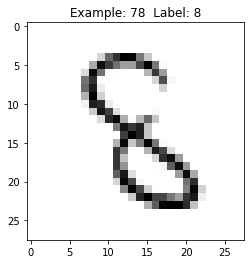

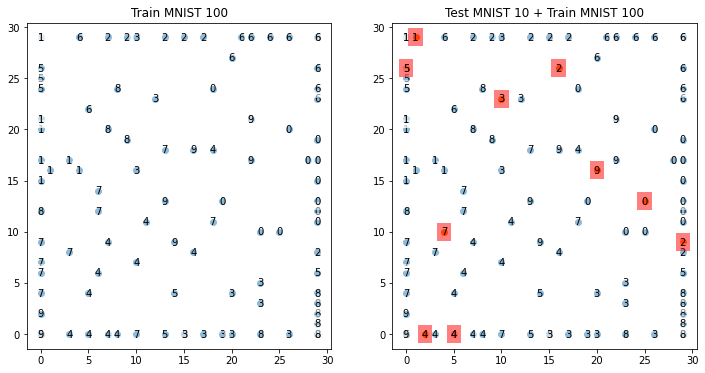

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import random as ran

## Applying SOM into Mnist data

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

def train_size(num):
    x_train = mnist.train.images[:num,:]
    y_train = mnist.train.labels[:num,:]
    return x_train, y_train

x_train, y_train = train_size(100)
x_test, y_test = train_size(110)
x_test = x_test[100:110,:]; y_test = y_test[100:110,:]

def display_digit(num):
    label = y_train[num].argmax(axis=0)
    image = x_train[num].reshape([28,28])
    plt.title('Example: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()

display_digit(ran.randint(0, x_train.shape[0]))

# Import som class and train into 30 * 30 sized of SOM lattice

som = SOM(30, 30, x_train.shape[1], 200)
som.train(x_train)

# Fit train data into SOM lattice
mapped = som.map_vects(x_train)
mappedarr = np.array(mapped)
x1 = mappedarr[:,0]; y1 = mappedarr[:,1]

index = [ np.where(r==1)[0][0] for r in y_train ]
index = list(map(str, index))

## Plots: 1) Train 2) Test+Train ###

plt.figure(1, figsize=(12,6))
plt.subplot(121)
# Plot 1 for Training only
plt.scatter(x1,y1)
# Just adding text
for i, m in enumerate(mapped):
    plt.text( m[0], m[1],index[i], ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, lw=0))
plt.title('Train MNIST 100')

# Testing
mappedtest = som.map_vects(x_test)
mappedtestarr = np.array(mappedtest)
x2 = mappedtestarr[:,0]
y2 = mappedtestarr[:,1]

index2 = [ np.where(r==1)[0][0] for r in y_test ]
index2 = list(map(str, index2))

plt.subplot(122)
# Plot 2: Training + Testing
plt.scatter(x1,y1)
# Just adding text
for i, m in enumerate(mapped):
    plt.text( m[0], m[1],index[i], ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, lw=0))

plt.scatter(x2,y2)
# Just adding text
for i, m in enumerate(mappedtest):
    plt.text( m[0], m[1],index2[i], ha='center', va='center', bbox=dict(facecolor='red', alpha=0.5, lw=0))
plt.title('Test MNIST 10 + Train MNIST 100')

plt.show()

1. Describe the nature of your input and sketch the architecture of your model
2. Explain what will the output of the training look like and please think it over how can we improve the accuracy of our training result.
3. how can the recognizing process be performed.

![alt text](https://drive.google.com/uc?id=1uQKkexiNUZLq6vdBXeF5Sh5EOOCshZqW)

1. The Input on the code is with tensorflow.examples.tutorials.mnist import input_data and split into 2 training and testing data and the training data is trained to fit into 30 x 30 SOM lattice. The sketch is like the picture above, the input vector is the input_data and the size of x and y is 30. 

2. The output training become a 30 by 30 grid, like the code outputted above.
SOM can be optimized by using Particle Swarm Optimisation (PSO) which from some research says can improve the trainning time without decresing the accuracy.

3. A Self-Organising Map, additionally, uses competitive learning as opposed to error-correction learning, to adjust it weights. This means that only a single node is activated at each iteration in which the features of an instance of the input vector are presented to the neural network, as all nodes compete for the right to respond to the input.
The chosen node — the Best Matching Unit (BMU) — is selected according to the similarity, between the current input values and all the nodes in the grid.